# Análise de sentimentos usando Aprendizado de Máquina

Este notebook tem como finalidade compilar os experimentos feitos para o projeto da disciplina de Inteligência Artificial da Unisagrado.

# Análise exploratória

## bibliotecas utilizadas

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

from pickle import dump

from nltk import tokenize, FreqDist

## Obtenção dos dados

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d luisfredgs/imdb-ptbr

 68% 33.0M/48.4M [00:00<00:00, 60.3MB/s]
100% 48.4M/48.4M [00:00<00:00, 71.9MB/s]


In [ ]:
!unzip /content/imdb-ptbr.zip

Archive:  /content/imdb-ptbr.zip
  inflating: imdb-reviews-pt-br.csv  


In [ ]:
data = pd.read_csv('/content/imdb-reviews-pt-br.csv')
data['classification'] = data['sentiment'].replace(['neg', 'pos'], [0, 1])

data.sample(5)

,id,text_en,text_pt,sentiment,classification
47086,47088,After repeated listenings to the CD soundtrack...,Após repetidas audições na trilha sonora do CD...,pos,1
4126,4128,Here we go another pop star breaking in to the...,Aqui vamos nós outra estrela pop invadindo a g...,neg,0
35935,35937,"I saw ""Myra Breckinridge"" when it first came o...","Eu vi ""Myra Breckinridge"" quando foi lançado p...",neg,0
6291,6293,Just to save you money and time I will go ahea...,Só para poupar dinheiro e tempo eu vou em fren...,neg,0
13938,13940,When A Stranger Calls is actually a pretty goo...,Quando A Stranger Calls é na verdade um filme ...,pos,1


## Insights iniciais

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def positive_word_cloud(text, text_column):
    positives = text.query("classification == 1")
    all_words = ' '.join([text for text in positives[text_column]])
    word_cloud = WordCloud(
        width=800, height=500,
        max_font_size=110,
        collocations=False
    ).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def negative_word_cloud(text, text_column):
    negatives = text.query("classification == 0")
    all_words = ' '.join([text for text in negatives[text_column]])
    word_cloud = WordCloud(
        width=800, height=500,
        max_font_size=110,
        collocations=False
    ).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

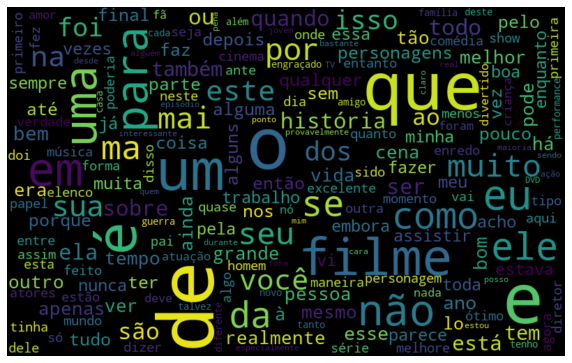

In [ ]:
positive_word_cloud(data, 'text_pt')

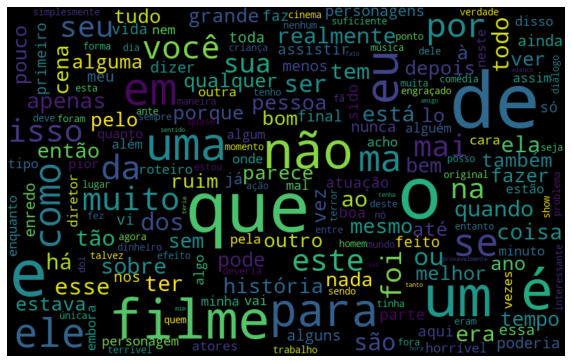

In [ ]:
negative_word_cloud(data, 'text_pt')

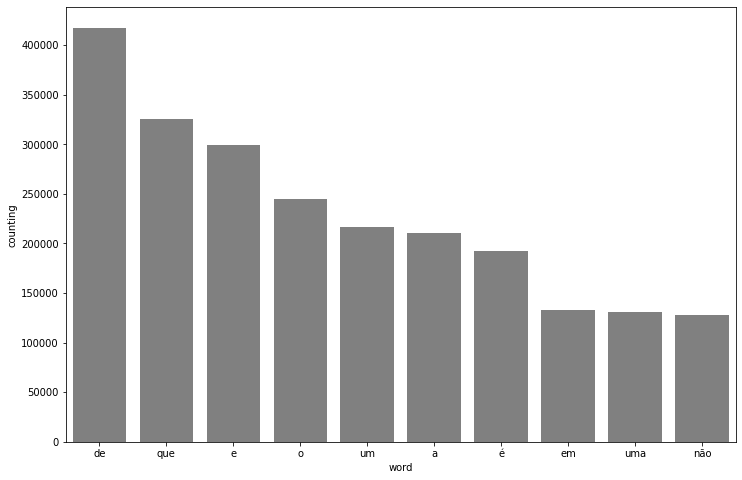

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def pareto(text, text_column, n_words):
    all_words = ' '.join([text for text in text[text_column]])
    tokens = tokenize.WhitespaceTokenizer().tokenize(all_words)
    frequency = FreqDist(tokens)

    df_frequency = pd.DataFrame({
        "word": list(frequency.keys()),
        "freq": list(frequency.values())
    })

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df_frequency.nlargest(
        columns='freq', n=n_words), x='word', y='freq', color='gray')
    ax.set(ylabel="counting")
    plt.show()

pareto(data, 'text_pt', 10)

In [ ]:
all_words = ' '.join([text for text in data['text_pt']])
tokens = tokenize.WhitespaceTokenizer().tokenize(all_words)

frequency = FreqDist(tokens)

df_frequency = pd.DataFrame({
        "word": list(frequency.keys()),
        "freq": list(frequency.values())
})

df_frequency.nlargest(columns='freq', n=10)

,word,freq
20,de,417651
14,que,325070
42,e,299743
3,o,244881
7,um,216410
102,a,210179
45,é,192381
200,em,132778
1,uma,130888
29,não,127915


## Pré-processamento

### Removendo stop-words

In [ ]:
import nltk


nltk.download('stopwords', quiet=True)

stop_words = nltk.corpus.stopwords.words('portuguese')

print(stop_words)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

In [ ]:
from string import punctuation

punctuations_list = []
for punct in punctuation:
  punctuations_list.append(punct) 

print(punctuations_list)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [ ]:
processed_phrases = []

for text in data['text_pt']:
  new_phrase = []
  text_words = tokenize.WordPunctTokenizer().tokenize(text)
  for word in text_words:
    if word not in stop_words:
      new_phrase.append(word)
  processed_phrases.append(' '.join(new_phrase))

data['treatment-1'] = processed_phrases


In [ ]:
data.sample(5)

,id,text_en,text_pt,sentiment,classification,treatment-1
35087,35089,Prom Night 2 is an OK horror movie but prom ni...,"Prom Night 2 é um filme de terror OK, mas a no...",neg,0,"Prom Night 2 filme terror OK , noite baile mel..."
1723,1724,I think I can safely say without really giving...,Eu acho que posso dizer com segurança sem real...,neg,0,Eu acho posso dizer segurança realmente dar na...
46107,46109,Buffs of the adult western that flourished in ...,Os entusiastas do faroeste adulto que floresce...,pos,1,Os entusiastas faroeste adulto floresceram déc...
12531,12533,Ed Harris and Cuba Gooding Jr. where cast perf...,"Ed Harris e Cuba Gooding Jr., que atuaram perf...",pos,1,"Ed Harris Cuba Gooding Jr ., atuaram perfeitam..."
23735,23737,Cant get much eerier than Flatliners. This dee...,Não posso ficar muito mais efervescente do que...,pos,1,Não posso ficar efervescente Flatliners . Esse...


In [ ]:
stop_words = stop_words + punctuations_list

processed_phrases = []

for text in data['text_pt']:
  new_phrase = []
  text_words = tokenize.WordPunctTokenizer().tokenize(text)
  for word in text_words:
    if word not in stop_words:
      new_phrase.append(word)
  processed_phrases.append(' '.join(new_phrase))

data['treatment-2'] = processed_phrases


In [ ]:
data.sample(5)

,id,text_en,text_pt,sentiment,classification,treatment-1,treatment-2
20307,20309,Reading the comments I am struck by the obviou...,"Lendo os comentários, fico impressionado com o...",pos,1,"Lendo comentários , fico impressionado efeito ...",Lendo comentários fico impressionado efeito ób...
48118,48120,Gentleman Jim not really a boxing film. It is ...,Gentleman Jim não é realmente um filme de boxe...,pos,1,Gentleman Jim realmente filme boxe . É veículo...,Gentleman Jim realmente filme boxe É veículo E...
12685,12687,This is easily my favourite film. A tragic rom...,Este é facilmente o meu filme favorito. Um rom...,pos,1,Este facilmente filme favorito . Um romance tr...,Este facilmente filme favorito Um romance trág...
30011,30013,Was convincing the world that he didnt exist.....,Foi convencer o mundo que ele não existia ... ...,neg,0,Foi convencer mundo existia ... Esta linha pro...,Foi convencer mundo existia ... Esta linha pro...
29556,29558,"Boris Karloff is Matthias Morteval, a dying, l...","Boris Karloff é Matthias Morteval, um louco e ...",neg,0,"Boris Karloff Matthias Morteval , louco solitá...",Boris Karloff Matthias Morteval louco solitári...


## Insights Modelo 01

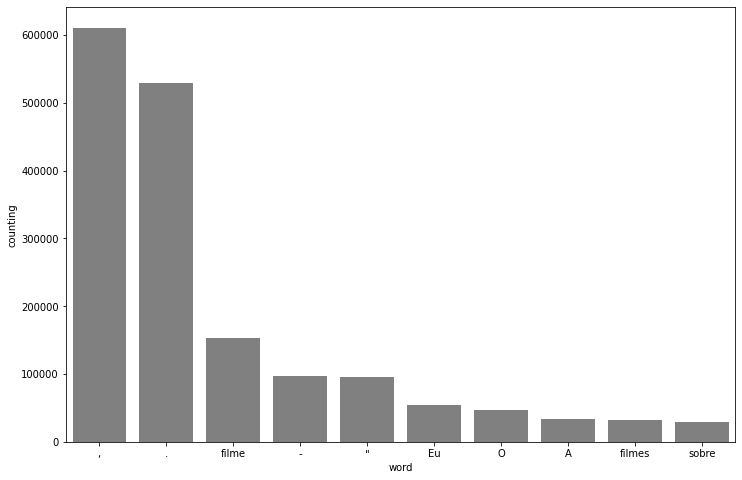

In [ ]:
pareto(data, 'treatment-1', 10)

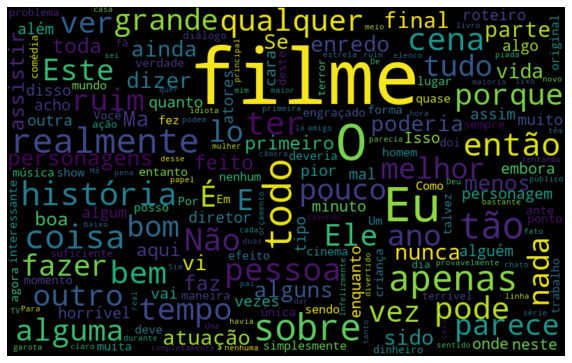

In [ ]:
negative_word_cloud(data, 'treatment-1')

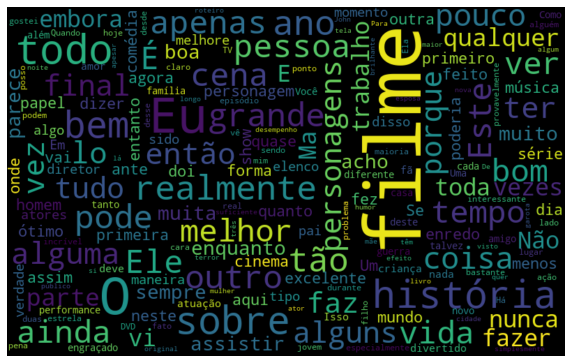

In [ ]:
positive_word_cloud(data, 'treatment-1')

## Insights Modelo 02

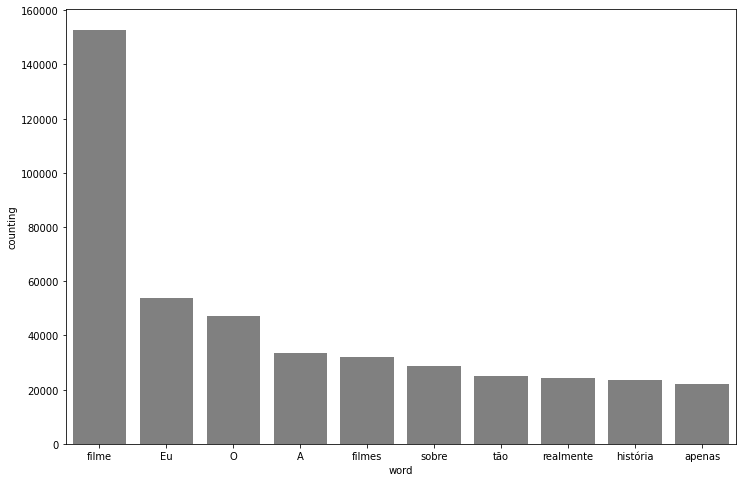

In [ ]:
pareto(data, 'treatment-2', 10)

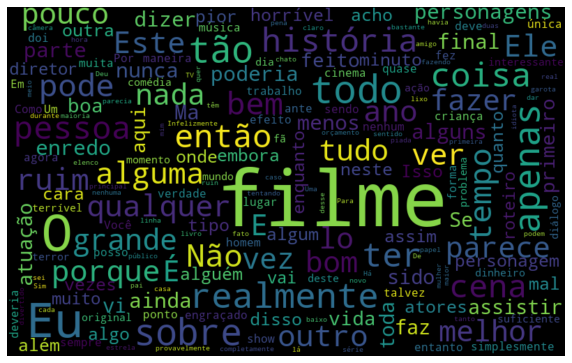

In [ ]:
negative_word_cloud(data, 'treatment-2')

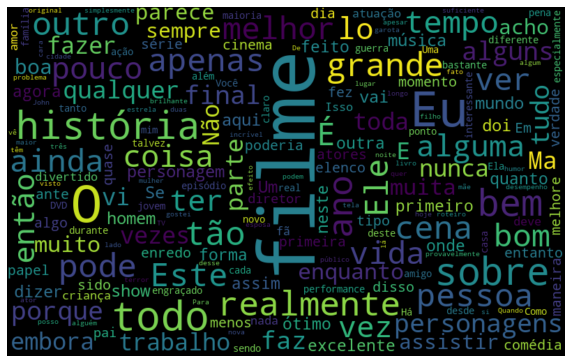

In [ ]:
positive_word_cloud(data, 'treatment-2')

## Insights Modelo 03

In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 8.5 MB/s 


In [ ]:
import unidecode

no_accent = [unidecode.unidecode(text) for text in data['treatment-2']]

In [ ]:
data['treatment-3'] = no_accent

In [ ]:
stop_words = stop_words + punctuations_list

processed_phrases = []

for text in data['treatment-3']:
  new_phrase = []
  text_words = tokenize.WordPunctTokenizer().tokenize(text)
  for word in text_words:
    if word not in stop_words:
      new_phrase.append(word)
  processed_phrases.append(' '.join(new_phrase))

data['treatment-3'] = processed_phrases

In [ ]:
data.sample(5)

,id,text_en,text_pt,sentiment,classification,treatment-1,treatment-2,treatment-3
8177,8179,Most predicable movie Ive ever seen...extremel...,O filme mais previsível que eu já vi ... extre...,neg,0,"O filme previsível vi ... extremamente chato ,...",O filme previsível vi ... extremamente chato s...,O filme previsivel vi ... extremamente chato s...
37390,37392,I first heard of this movie after purchasing t...,Eu ouvi pela primeira vez sobre este filme dep...,pos,1,Eu ouvi primeira vez sobre filme comprar filme...,Eu ouvi primeira vez sobre filme comprar filme...,Eu ouvi primeira vez sobre filme comprar filme...
11937,11939,"If you live in the suburbs, are relatively wel...","Se você mora nos subúrbios, está relativamente...",neg,0,"Se mora subúrbios , relativamente bem financei...",Se mora subúrbios relativamente bem financeira...,Se mora suburbios relativamente bem financeira...
20858,20860,"Love this little film, that reminds me somewha...","Adoro este pequeno filme, que me lembra um pou...",pos,1,"Adoro pequeno filme , lembra pouco joia japone...",Adoro pequeno filme lembra pouco joia japonesa...,Adoro pequeno filme lembra pouco joia japonesa...
44573,44575,Includes Spoilers Ive been a horror film fan n...,Inclui Spoilers Eu tenho sido um fã de filmes ...,pos,1,Inclui Spoilers Eu sido fã filmes terror agora...,Inclui Spoilers Eu sido fã filmes terror agora...,Inclui Spoilers Eu sido fa filmes terror agora...


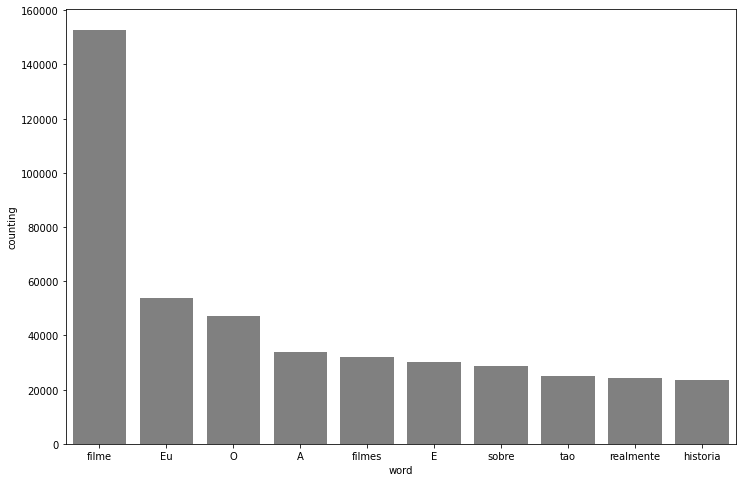

In [ ]:
pareto(data, 'treatment-3', 10)

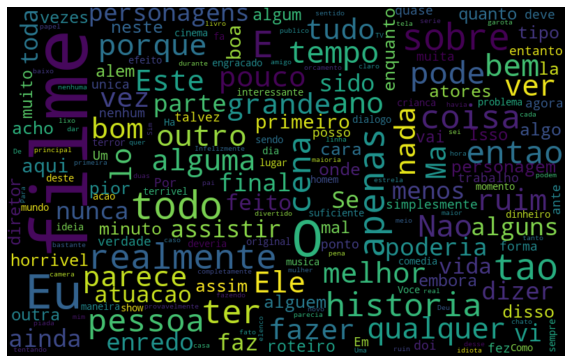

In [ ]:
negative_word_cloud(data, 'treatment-3')

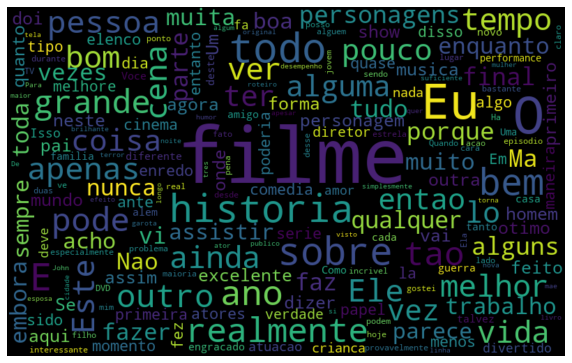

In [ ]:
positive_word_cloud(data, 'treatment-3')

## Modelo 4

In [ ]:
processed_phrases = []

for text in data['treatment-3']:
  new_phrase = []
  text = text.lower()
  text_words = tokenize.WordPunctTokenizer().tokenize(text)
  for word in text_words:
    if word not in no_accent:
      new_phrase.append(word)
  processed_phrases.append(' '.join(new_phrase))

data['treatment-4'] = processed_phrases

KeyboardInterrupt: ignored

In [ ]:
data.sample(5)

## Modelo 5

In [ ]:
from nltk import RSLPStemmer
import nltk

nltk.download('rslp', quiet=True)
stemmer = RSLPStemmer()

processed_phrases = []

for text in data['treatment-3']:
  new_phrase = []
  text = text.lower()
  text_words = tokenize.WordPunctTokenizer().tokenize(text)
  for word in text_words:
    if word not in no_accent:
      new_phrase.append(stemmer.stem(word))
  processed_phrases.append(' '.join(new_phrase))

data['treatment-5'] = processed_phrases

KeyboardInterrupt: ignored

In [ ]:
data.sample(5)

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

from nltk import tokenize, FreqDist

from pickle import dump

def classify_text(text, text_column, classification_column):
    vectorizer = CountVectorizer(max_features=50)
    bag_of_words = vectorizer.fit_transform(text[text_column])

    train, test, train_class, test_class = train_test_split(
        bag_of_words, text[classification_column])

    logistic_regressor = LogisticRegression()
    logistic_regressor.fit(train, train_class)

    return (
        logistic_regressor.score(test, test_class),
        logistic_regressor,
        vectorizer
    )

accuracy, model, vec = classify_text(data, 'treatment-3', 'classification')

if accuracy >= 0.6:
    with open("regressor_model.pkl", "wb") as file:
        dump(model, file, protocol=None, fix_imports=True)
        print("model saved successfully")
    with open("regressor_vectorizer.pkl", "wb") as file:
        dump(vec, file, protocol=None, fix_imports=True)
        print("vectorizer saved successfully")
else:
    print('model has no enough performance')

print(f'current accuracy: {(accuracy * 100):.2f}%')

model saved successfully
vectorizer saved successfully
current accuracy: 66.54%


## Aprendizado

In [ ]:
def classify_text(text, text_column, classification_column):
    vectorizer = CountVectorizer(max_features=50)
    bag_of_words = vectorizer.fit_transform(text[text_column])

    train, test, train_class, test_class = train_test_split(
        bag_of_words, text[classification_column])

    logistic_regressor = LogisticRegression()
    logistic_regressor.fit(train, train_class)

    return (
        logistic_regressor.score(test, test_class),
        logistic_regressor
    )

In [ ]:
accuracy, _ = classify_text(data, 'treatment-1', 'classification')
print(f'current accuracy: {(accuracy * 100):.2f}%')

In [ ]:
accuracy, _ = classify_text(data, 'treatment-2', 'classification')
print(f'current accuracy: {(accuracy * 100):.2f}%')

In [ ]:
accuracy, _ = classify_text(data, 'treatment-3', 'classification')
print(f'current accuracy: {(accuracy * 100):.2f}%')

In [ ]:
accuracy, model = classify_text(data, 'treatment-4', 'classification')

if accuracy >= 0.6:
    with open("regressor_model.pkl", "wb") as file:
        dump(model, file, protocol=None, fix_imports=True)
        print("model saved successfully")
else:
    print('model has no enough performance')

print(f'current accuracy: {(accuracy * 100):.2f}%')

### teste

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

from pickle import dump
from string import punctuation

import nltk
from nltk import tokenize, FreqDist

import unidecode


def classify_text(text, text_column, classification_column):
    bag_of_words = CountVectorizer(
      max_features=50
    ).fit_transform(text[text_column])

    train, test, train_class, test_class = train_test_split(
        bag_of_words,
        text[classification_column]
    )

    logistic_regressor = LogisticRegression(
      solver='lbfgs',
      multi_class='ovr'
    ).fit(train, train_class)

    return (
        logistic_regressor.score(test, test_class),
        logistic_regressor
    )


data = pd.read_csv('dataset/imdb-reviews-pt-br.csv')
data['classification'] = data['sentiment'].replace(['neg', 'pos'], [0, 1])

nltk.download('stopwords', quiet=True)
stop_words = nltk.corpus.stopwords.words('portuguese')

punctuations_list = []
for punt in punctuation:
  punctuations_list.append(punt)

stop_words = stop_words + punctuations_list

no_accent = [unidecode.unidecode(text) for text in data['text_pt']]
data['treatment'] = no_accent

processed_phrases = []
for text in data['treatment']:
  new_phrase = []
  text = text.lower()
  text_words = tokenize.WordPunctTokenizer().tokenize(text)
  for word in text_words:
    if word not in stop_words:
      new_phrase.append(word)
  processed_phrases.append(' '.join(new_phrase))

data['final_treatment'] = processed_phrases

accuracy, model = classify_text(data, 'final_treatment', 'classification')

if accuracy >= 0.6:
    with open("regressor_model.pkl", "wb") as file:
        dump(model, file, protocol=None, fix_imports=True)
        print("model saved successfully")
else:
    print('model has no enough performance')

print(f'current accuracy: {(accuracy * 100):.2f}%')


# Referência